### Fifa 22 Complete Player Dataset [UPD:01/10/21]

##### Content

Replaced positions that do not exist in fifa, for example ["LS", "RS"] with "ST".
And a few more brief introductory notes:

- monetary values in Euro;
- height in cm;
- weight in kg;
- players without clubs in the Clubs column - "Free agent"
- players who are not include to national teams in the column "NationalTeam" - "Not in team"

##### Hypotesis


In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('players_fifa22.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19260 entries, 0 to 19259
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 19260 non-null  int64  
 1   Name               19260 non-null  object 
 2   FullName           19260 non-null  object 
 3   Age                19260 non-null  int64  
 4   Height             19260 non-null  int64  
 5   Weight             19260 non-null  int64  
 6   PhotoUrl           19260 non-null  object 
 7   Nationality        19260 non-null  object 
 8   Overall            19260 non-null  int64  
 9   Potential          19260 non-null  int64  
 10  Growth             19260 non-null  int64  
 11  TotalStats         19260 non-null  int64  
 12  BaseStats          19260 non-null  int64  
 13  Positions          19260 non-null  object 
 14  BestPosition       19260 non-null  object 
 15  Club               19260 non-null  object 
 16  ValueEUR           192

In [4]:
df.isna().sum().sort_values(ascending=False)

NationalNumber       18503
NationalPosition     18503
ClubNumber              76
ContractUntil           76
ClubPosition            76
                     ...  
DefensiveWorkRate        0
AttackingWorkRate        0
SkillMoves               0
WeakFoot                 0
GKRating                 0
Length: 90, dtype: int64

In [15]:
df['Nationality'].isna().sum()

0

In [24]:
df_main = df.copy()
df_main = df_main.loc[:, ['Age', 'Height', 'Weight', 'Overall', 'Potential', 'Growth', 'BaseStats', 'TotalStats', 'ValueEUR', 'WageEUR', 'PreferredFoot']]
df_main.isna().sum().sort_values(ascending=False)

Age              0
Height           0
Weight           0
Overall          0
Potential        0
Growth           0
BaseStats        0
TotalStats       0
ValueEUR         0
WageEUR          0
PreferredFoot    0
dtype: int64

In [25]:
df_main.describe()

,Age,Height,Weight,Overall,Potential,Growth,BaseStats,TotalStats,ValueEUR,WageEUR
count,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,1.926000e+04,19260.000000
mean,25.184683,181.305036,74.950779,65.815628,71.100104,5.284476,357.062461,1598.525909,2.857652e+06,8973.528037
std,4.737340,6.866151,7.066864,6.817297,6.092103,5.472201,39.910613,271.575855,7.604532e+06,19415.497147
min,16.000000,155.000000,49.000000,48.000000,49.000000,0.000000,227.000000,767.000000,0.000000e+00,0.000000
25%,21.000000,176.000000,70.000000,62.000000,67.000000,0.000000,329.000000,1462.000000,4.750000e+05,1000.000000
50%,25.000000,181.000000,75.000000,66.000000,71.000000,4.000000,358.000000,1633.000000,9.750000e+05,3000.000000
75%,29.000000,186.000000,80.000000,70.000000,75.000000,9.000000,384.000000,1782.000000,2.000000e+06,8000.000000
max,54.000000,206.000000,110.000000,93.000000,95.000000,26.000000,501.000000,2341.000000,1.940000e+08,350000.000000


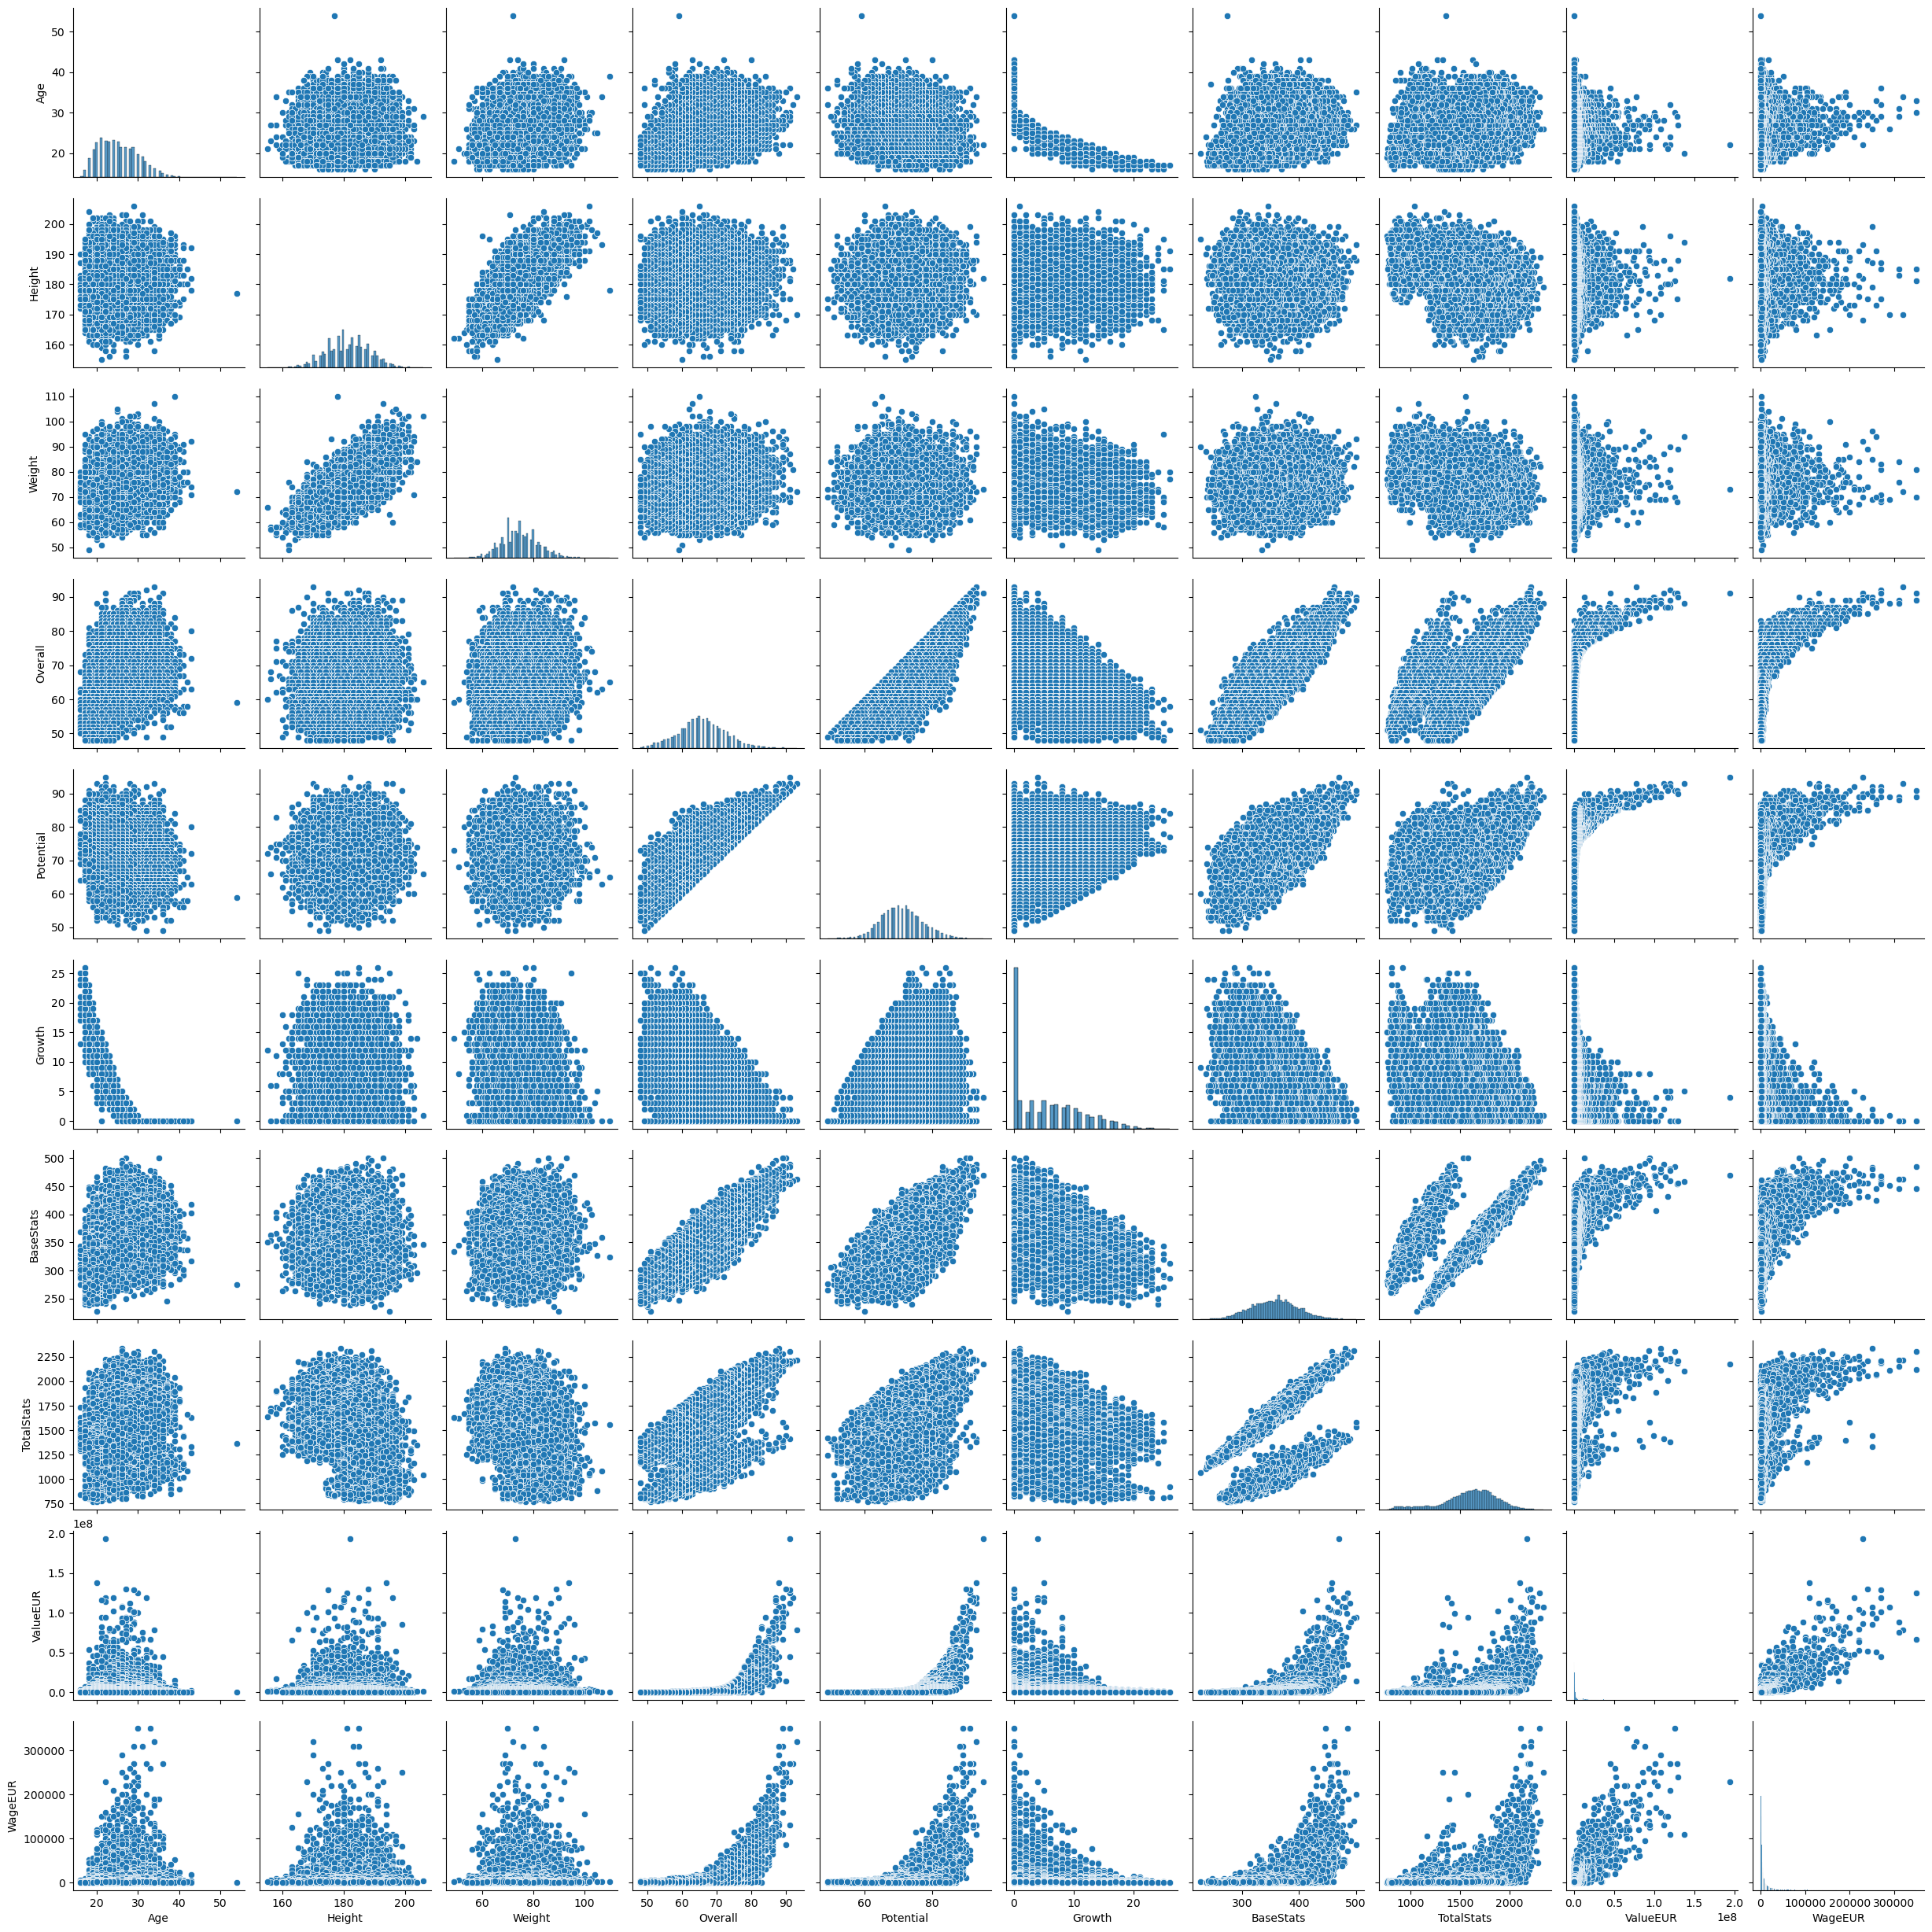

In [26]:
# df_main['Nationality'].value_counts()
sns.pairplot(df_main)